In [22]:
#NOTE: ARIMA models are only able to predict q steps into the future

In [1]:
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Download stock data for Apple (AAPL)
ticker = 'AAPL'
data = yf.download(ticker, start='2018-01-01', end='2023-01-01')

# Preview the data
print(data.head())

[*********************100%***********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2018-01-02  42.540001  43.075001  42.314999  43.064999  40.568928  102223600
2018-01-03  43.132500  43.637501  42.990002  43.057499  40.561874  118071600
2018-01-04  43.134998  43.367500  43.020000  43.257500  40.750271   89738400
2018-01-05  43.360001  43.842499  43.262501  43.750000  41.214233   94640000
2018-01-08  43.587502  43.902500  43.482498  43.587502  41.061142   82271200


In [3]:
# Use the 'Close' prices for the model
close_prices = data['Close']

In [4]:
# Split the data into training and testing sets
train = close_prices[:int(0.8 * len(close_prices))]
test = close_prices[int(0.8 * len(close_prices)):]

In [10]:
# Set frequency for the training index
train.index = pd.date_range(start=train.index[0], periods=len(train), freq='B')

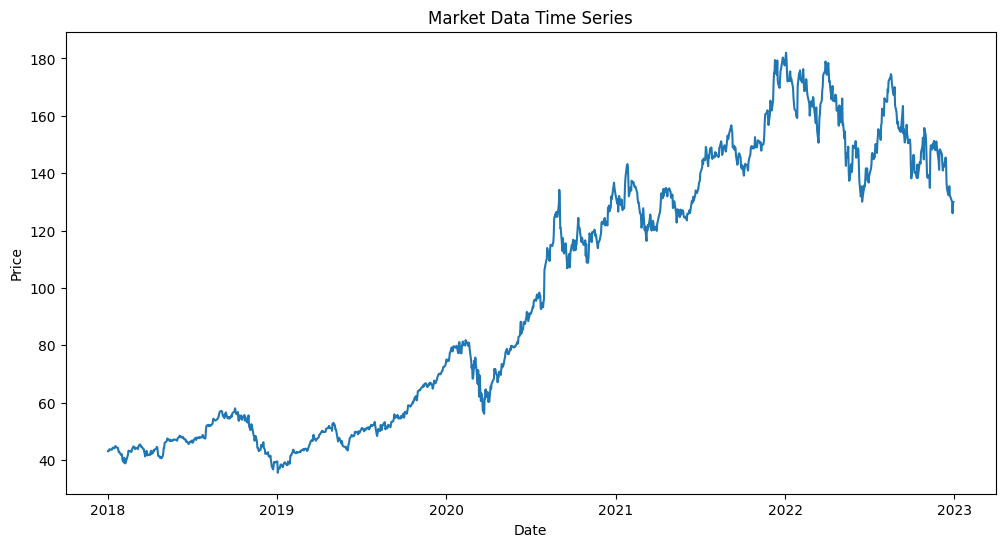

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(close_prices)
plt.title('Market Data Time Series')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [6]:
from statsmodels.tsa.stattools import adfuller

# First differencing
diff_data = train.diff().dropna()

# Check for stationarity again
result = adfuller(diff_data)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -6.470726961279911
p-value: 1.3692949509986417e-08


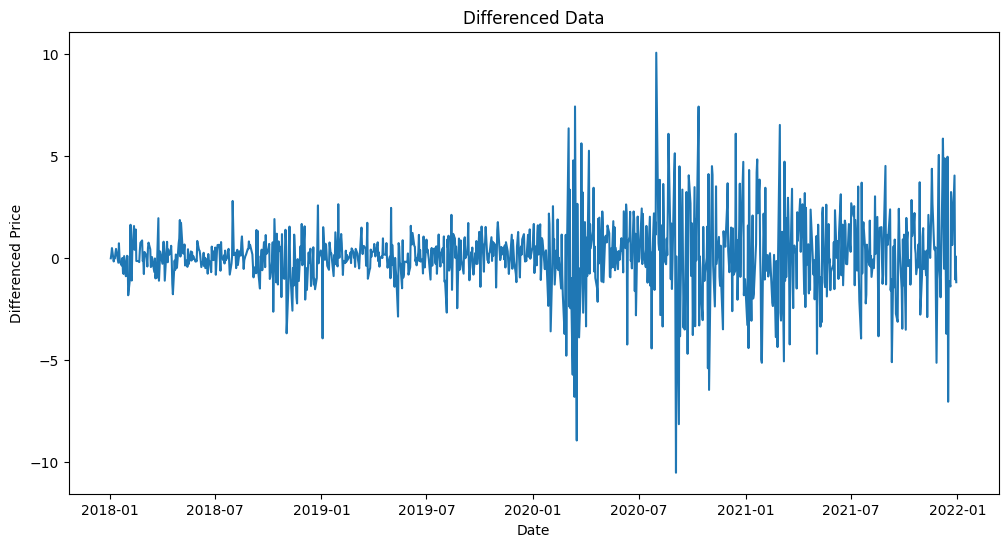

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(diff_data)
plt.title('Differenced Data')
plt.xlabel('Date')
plt.ylabel('Differenced Price')
plt.show()

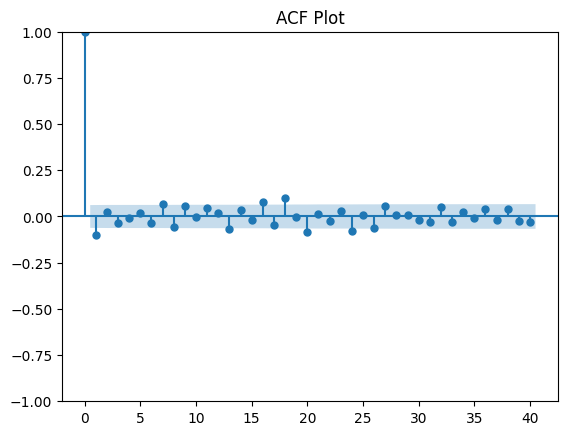

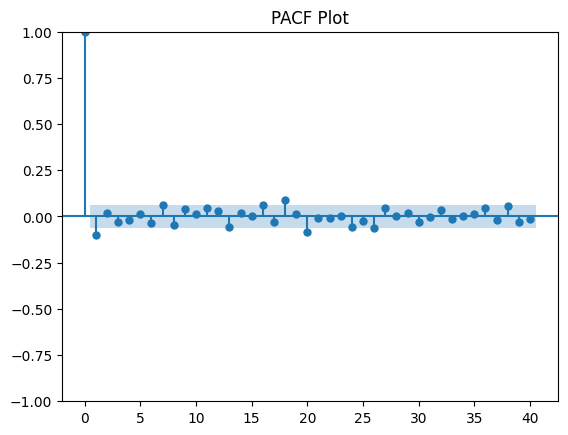

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sm.graphics.tsa.plot_acf(diff_data, lags=40)
plt.title('ACF Plot')
plt.show()

sm.graphics.tsa.plot_pacf(diff_data, lags=40)
plt.title('PACF Plot')
plt.show()

In [11]:
from statsmodels.tsa.arima.model import ARIMA

# Define your ARIMA order
p, d, q = 1, 1, 0
# Fit the ARIMA model using the differenced data
arima_model = ARIMA(train, order=(p, d, q)).fit()

# Print the summary of the model
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1007
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2021.830
Date:                Mon, 23 Sep 2024   AIC                           4047.660
Time:                        14:53:47   BIC                           4057.488
Sample:                    01-02-2018   HQIC                          4051.394
                         - 11-10-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0928      0.021     -4.517      0.000      -0.133      -0.053
sigma2         3.2597      0.079     41.208      0.000       3.105       3.415
Ljung-Box (L1) (Q):                   0.02   Jarque-

In [24]:
#NOTE: for a (0,1,0) model, the prediction is just the last observed value
#https://stats.stackexchange.com/questions/135651/arima-predictions-constant

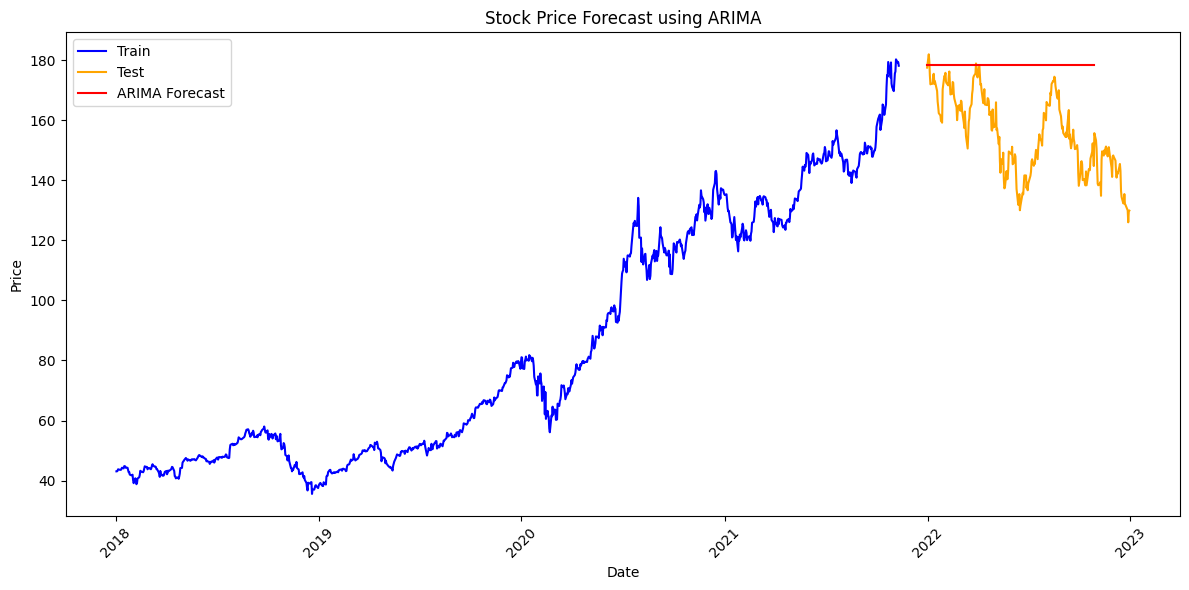

In [19]:
# Forecast the test period
forecast_steps = len(test)  # Number of steps to forecast
arima_forecast = arima_model.forecast(steps=forecast_steps)

# Prepare the forecast series with the correct index
arima_forecast_index = test.index  # Use the test index
arima_forecast_series = pd.Series(arima_forecast, index=arima_forecast_index)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(arima_forecast_series.index, arima_forecast_series, label='ARIMA Forecast', color='red')
plt.legend(loc='best')
plt.title('Stock Price Forecast using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


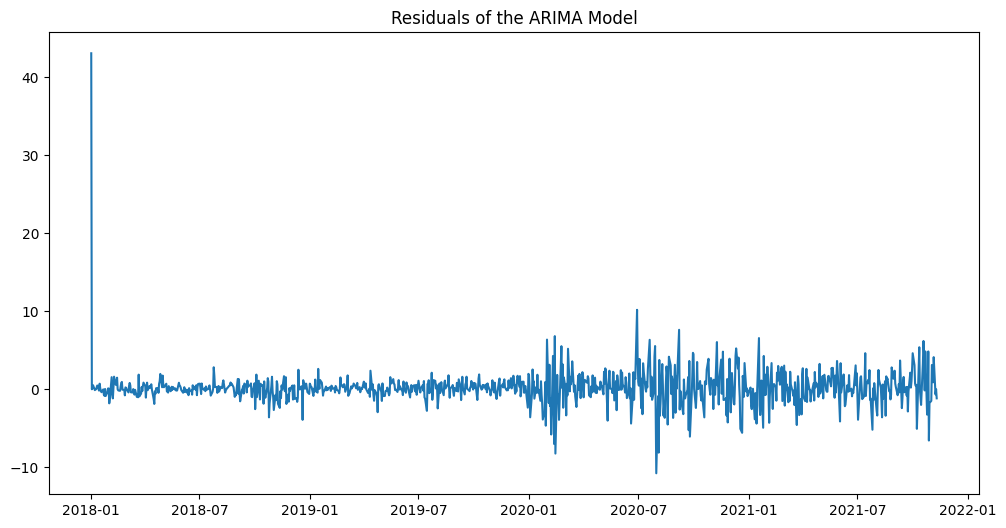

In [13]:
residuals = arima_model.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals of the ARIMA Model')
plt.show()

In [20]:
from pmdarima import auto_arima

# Fit the model using auto_arima
auto_arima_model = auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True)

# Print the summary of the best model
print(auto_arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1007
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -2018.470
Date:                Mon, 23 Sep 2024   AIC                           4042.939
Time:                        14:59:43   BIC                           4057.680
Sample:                    01-02-2018   HQIC                          4048.540
                         - 11-10-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1478      0.057      2.585      0.010       0.036       0.260
ar.L1         -0.0989      0.021     -4.792      0.000      -0.139      -0.058
sigma2         3.2380      0.078     41.484      0.0

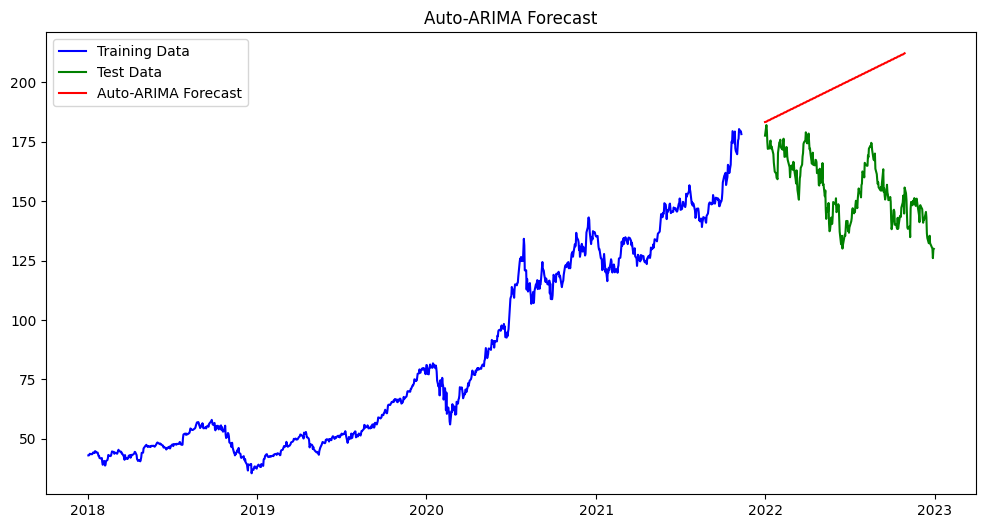

In [21]:
# Define the number of steps to forecast
forecast_steps = len(test)

# Generate forecasts
auto_arima_forecast = auto_arima_model.predict(n_periods=forecast_steps)

# Prepare for plotting
forecast_index = test.index  # Use test index
auto_arima_forecast_series = pd.Series(auto_arima_forecast, index=forecast_index)

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Test Data', color='green')
plt.plot(auto_arima_forecast_series.index, auto_arima_forecast_series, label='Auto-ARIMA Forecast', color='red')
plt.title('Auto-ARIMA Forecast')
plt.legend()
plt.show()